In [64]:
from pathlib import Path

import numpy as np
import torch
import torch_geometric as pyg
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from torch_geometric.data import Batch, Data
import functorch
import copy
from ocpmodels.transfer_learning.models.distribution_regression import (
    GaussianKernel,
    KernelMeanEmbeddingRidgeRegression,
    LinearMeanEmbeddingKernel,
    StandardizedOutputRegression,
    median_heuristic,
)

from ocpmodels.transfer_learning.common.utils import (
    ATOMS_TO_GRAPH_KWARGS,
    load_xyz_to_pyg_batch,
    load_xyz_to_pyg_data,
)
from ocpmodels.transfer_learning.loaders import BaseLoader

In [22]:
%cd python_lang/ocp

/home/isak/life/references/projects/src/python_lang/ocp


In [34]:
#%cd ../..
### Load checkpoint
CHECKPOINT_PATH = Path("checkpoints/s2ef_efwt/all/schnet/schnet_all_large.pt")
checkpoint = torch.load(CHECKPOINT_PATH, map_location="cpu")

### Load data
DATA_PATH = Path("data/luigi/example-traj-Fe-N2-111.xyz")
raw_data, data_batch, num_frames, num_atoms = load_xyz_to_pyg_batch(DATA_PATH, ATOMS_TO_GRAPH_KWARGS["schnet"])
raw_data, data_list, num_frames, num_atoms = load_xyz_to_pyg_data(DATA_PATH, ATOMS_TO_GRAPH_KWARGS["schnet"])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

representation_layer = 2
base_loader = BaseLoader(
    checkpoint["config"],
    representation=True,
    representation_kwargs={
        "representation_layer": representation_layer,
    },
)
base_loader.load_checkpoint(CHECKPOINT_PATH, strict_load=False)
model = base_loader.model
model.to(device)
model.mekrr_forces = True
model.regress_forces = False

	Unexpected key(s) in state_dict: "atomic_mass", "interactions.2.mlp.0.weight", "interactions.2.mlp.0.bias", "interactions.2.mlp.2.weight", "interactions.2.mlp.2.bias", "interactions.2.conv.lin1.weight", "interactions.2.conv.lin2.weight", "interactions.2.conv.lin2.bias", "interactions.2.conv.nn.0.weight", "interactions.2.conv.nn.0.bias", "interactions.2.conv.nn.2.weight", "interactions.2.conv.nn.2.bias", "interactions.2.lin.weight", "interactions.2.lin.bias", "interactions.3.mlp.0.weight", "interactions.3.mlp.0.bias", "interactions.3.mlp.2.weight", "interactions.3.mlp.2.bias", "interactions.3.conv.lin1.weight", "interactions.3.conv.lin2.weight", "interactions.3.conv.lin2.bias", "interactions.3.conv.nn.0.weight", "interactions.3.conv.nn.0.bias", "interactions.3.conv.nn.2.weight", "interactions.3.conv.nn.2.bias", "interactions.3.lin.weight", "interactions.3.lin.bias", "interactions.4.mlp.0.weight", "interactions.4.mlp.0.bias", "interactions.4.mlp.2.weight", "interactions.4.mlp.2.bias", "

In [67]:
class LinearKernel:
    def __init__(self):
        pass
    def __call__(self, x, y):
        return x @ y.T

lkernel = LinearMeanEmbeddingKernel(LinearKernel())

frames = 2
dat = Batch.from_data_list(data_batch[:frames]).to(device)
dat.pos.requires_grad = True

In [36]:
def lin_op(c_0, c_1, dat, kernel):
    latent_vars = model(dat)[0]
    latent_vars = latent_vars.reshape((-1, num_atoms, latent_vars.shape[-1])).clone()
    def model_wrapper(pos, **data):
        data["pos"] = pos
        data = Data.from_dict(data).to(device)
        return model(data)[0]
    _dat = copy.deepcopy(dat).to_dict()
    pos = _dat.pop("pos")

    c_0 = kernel(latent_vars, latent_vars)@c_0
    print(c_0.shape)
    jvp =  torch.autograd.functional.jvp(lambda x: kernel(model_wrapper(x, **_dat).reshape(-1, num_atoms, latent_vars.shape[-1]), latent_vars), pos, c_1)[1]
    print(jvp.shape)
    c_1 = c_1
    return c_0, c_1

In [37]:
_ = lin_op(c_0, c_1, dat, lkernel)

NameError: name 'c_0' is not defined

In [68]:
gk = GaussianKernel()
gk.sigma = 1.0
gklme = LinearMeanEmbeddingKernel(gk)

In [39]:
kernel = gklme
T, n = frames, num_atoms
latent_vars = model(dat)
d = latent_vars.shape[-1]
latent_vars = latent_vars.reshape((T, n, d)).clone().detach()
def model_wrapper(pos_tensor, **data):
    T, n, _ = pos_tensor.shape
    data["pos"] = pos.reshape(-1, 3)
    data = Data.from_dict(data).to(device)
    return model(data).reshape(T, n, -1)
_dat = copy.deepcopy(dat).to_dict()
pos = _dat.pop("pos")

# Initialize things
c0 = torch.zeros(T, 1).to(device)
c1 = torch.zeros(T, n, 3).to(device)
# Kernel
with torch.no_grad():
    h = model(dat)
    h = h.reshape(T, n, d)
    sigma = median_heuristic(h, h)
gklme.kernel.sigma = sigma
    
lmbda = 1e-4
k = kernel(h, h) 
klmbda = (k - k.diag().diag()) + (lmbda + k.diag()).diag()
# First part
a0 = klmbda @ c0
# a0 += /

In [29]:
#func = lambda x: kernel(model_wrapper(x, **_dat), latent_vars)
def func(x, **_dat):
    return model_wrapper(x, **_dat)
    #return x.sum()

pos_tensor = pos.reshape(T, n, 3)
f = lambda x: func(x, **_dat)
y = f(pos_tensor)
out, jvp =  torch.autograd.functional.jvp(f, pos_tensor, torch.ones_like(pos_tensor), strict=True)
print(out)
print(jvp)

RuntimeError: The output of the user-provided function is independent of input 0. This is not allowed in strict mode.

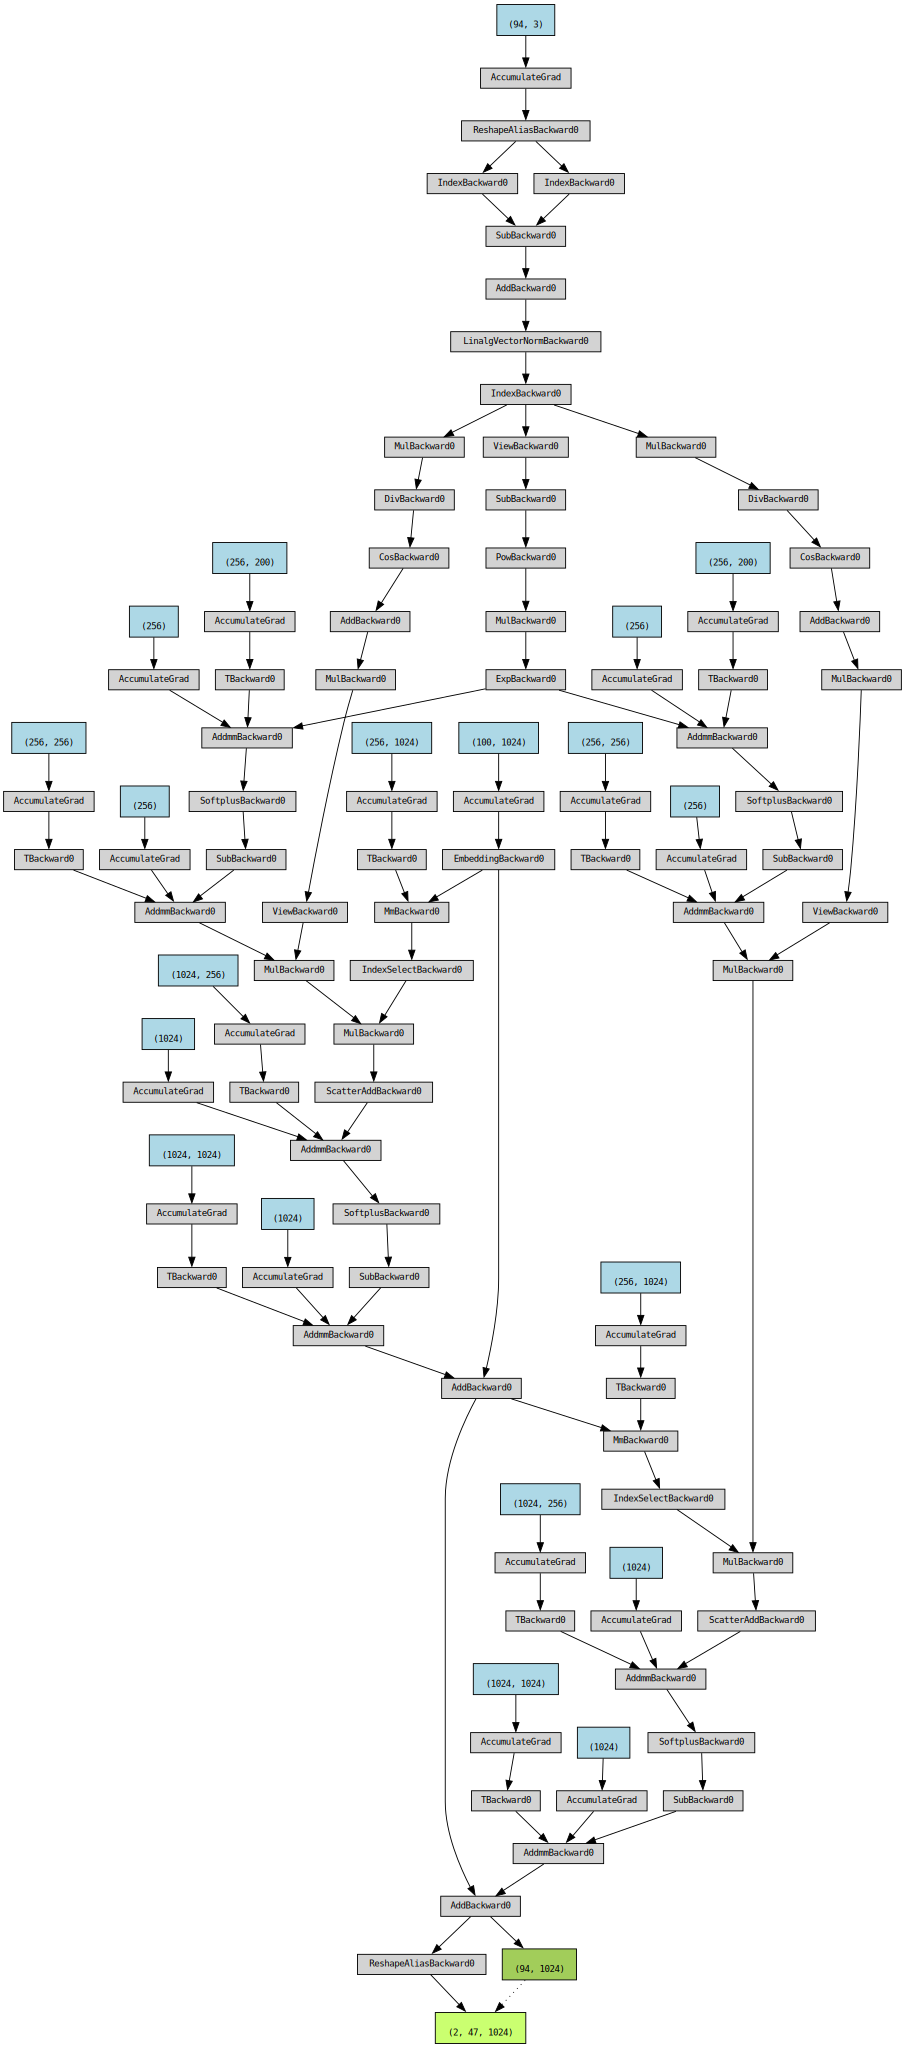

In [30]:
from torchviz import make_dot

make_dot(y, params={"pos": pos_tensor})

In [12]:
model(dat)

In [13]:
c1 = torch.zeros(T, n, 3).to(device)
y_pred = f(pos_tensor)
grad_pred = (
            torch.autograd.grad(
                y_pred,
                pos,
                grad_outputs=torch.ones_like(y_pred),
                create_graph=False,
                allow_unused=False,
            )[0]
)
grad_pred.sum()

In [14]:
##### _c1 = torch.zeros(T, n, 3)
out_dict = {"out": [], "jvp": []}
for t in range(T):
    _dat = dat[t].to_dict()
    pos = _dat.pop("pos")
    func = lambda x: kernel(model_wrapper(x, **_dat).reshape(1, n, d), latent_vars)
    out, jvp =  torch.autograd.functional.jvp(func, pos[t], c1[t].reshape(1, n, 3))
    out_dict["out"].append(out)
    out_dict["jvp"].append(jvp)
    
out = torch.cat(out_dict["out"])
jvp = torch.cat(out_dict["jvp"])

In [17]:
print(jvp)

In [ ]:
jvp =  torch.autograd.functional.jvp(lambda x: kernel(model_wrapper(x, **_dat).reshape(-1, num_atoms, latent_vars.shape[-1]), latent_vars), pos, c_1)[1]

In [ ]:
print(pos.shape, func(pos).shape)

In [ ]:
def f(pos, data, model, kernel):
    h = model(data)[0]
    h_ = h.clone().detach()
    return kernel(h, h_)


y = f(
    pos,
    dat,
    model,
    lkernel,
)
m = y.shape[0]
gr = torch.autograd.grad(
    outputs=y,
    inputs=pos,
    grad_outputs=torch.ones_like(y),
    retain_graph=False,
    create_graph=False,
    allow_unused=False,
    is_grads_batched=False,
)[0]
pos.shape
gr.shape

output, vjp_fn = torch.func.vjp(lambda x: f(x, dat, model, lkernel), pos)

# Temp

In [31]:
# First we check that we can get gradients

In [32]:
def f(pos, data, model, kernel):
    h = model(data)[0]
    h_ = h.clone().detach()
    return kernel(h, h_)


y = f(
    pos,
    dat,
    model,
    lkernel,
)
m = y.shape[0]
gr = torch.autograd.grad(
    outputs=y,
    inputs=pos,
    grad_outputs=torch.ones_like(y),
    retain_graph=False,
    create_graph=False,
    allow_unused=False,
    is_grads_batched=False,
)[0]

ValueError: not enough values to unpack (expected 3, got 1)

In [58]:
phi = model(dat)

In [59]:
def gradient(y, x, grad_outputs=None):
    """Compute dy/dx @ grad_outputs"""
    if grad_outputs is None:
        grad_outputs = torch.ones_like(y)
    grad = torch.autograd.grad(y, [x], grad_outputs = grad_outputs, create_graph=True)[0]
    return grad

def jacobian(y, x):
    """Compute dy/dx = dy/dx @ grad_outputs; 
    for grad_outputs in[1, 0, ..., 0], [0, 1, 0, ..., 0], ...., [0, ..., 0, 1]"""
    jac = torch.zeros(y.shape[0], x.shape[0]) 
    for i in range(y.shape[0]):
        grad_outputs = torch.zeros_like(y)
        grad_outputs[i] = 1
        jac[i] = gradient(y, x, grad_outputs = grad_outputs)
    return jac

In [60]:
J = jacobian(phi, dat.pos)

RuntimeError: expand(torch.FloatTensor{[94, 3]}, size=[94]): the number of sizes provided (1) must be greater or equal to the number of dimensions in the tensor (2)

In [84]:
def f(pos, data, model):
    h = model(data).reshape(frames, num_atoms, d)
    return h


y = f(
    dat.pos,
    dat,
    model,
)
m = y.shape[0]
gr = torch.autograd.grad(
    outputs=y,
    inputs=dat.pos,
    grad_outputs=torch.ones_like(y),
    retain_graph=False,
    create_graph=False,
    allow_unused=False,
    is_grads_batched=False,
)[0]

output, vjp_fn = torch.func.vjp(lambda x: f(x, dat, model), dat.pos)

RuntimeError: Cannot access data pointer of Tensor that doesn't have storage

In [89]:
def gradient(y, x, grad_outputs=None):
    """Compute dy/dx @ grad_outputs"""
    if grad_outputs is None:
        grad_outputs = torch.ones_like(y)
    grad = torch.autograd.grad(y, [x], grad_outputs = grad_outputs, create_graph=True)[0]
    return grad

def jacobian(y, x):
    """Compute dy/dx = dy/dx @ grad_outputs; 
    for grad_outputs in[1, 0, ..., 0], [0, 1, 0, ..., 0], ...., [0, ..., 0, 1]"""
    jac = torch.zeros(y.shape[0], x.shape[0]) 
    for i in range(y.shape[0]):
        grad_outputs = torch.zeros_like(y)
        grad_outputs[i] = 1
        jac[i] = gradient(y, x, grad_outputs = grad_outputs)
    return jac

In [99]:
dat_dict = dat.to_dict()
print(dat_dict.keys())

dict_keys(['pos', 'cell', 'atomic_numbers', 'natoms', 'tags', 'edge_index', 'cell_offsets', 'y', 'force', 'fixed', 'batch', 'ptr'])


In [100]:
data_keys = list(dat_dict.keys())

In [119]:
def f(pos, cell, atomic_numbers, natoms, tags, edge_index, cell_offsets, y, force, fixed, batch, ptr, model):
    data = Data.from_dict({
        "pos": pos,
        "cell": cell,
        "atomic_numbers": atomic_numbers,
        "natoms": natoms, 
        "tags": tags,
        "edge_index": edge_index, 
        "cell_offsets": cell_offsets,
        "y": y,
        "force": force,
        "fixed": fixed,
        "batch": batch,
        "ptr": ptr
    })
    h = model(data)
    return h

dat_dict = dat.to_dict()
pos = dat_dict.pop("pos")
y = f(pos=pos, **dat_dict, model=model)

gr = torch.autograd.grad(
    outputs=y,
    inputs=pos,
    grad_outputs=torch.ones_like(y),
    retain_graph=False,
    create_graph=False,
    allow_unused=False,
    is_grads_batched=False,
)[0]

func_output, jvp = torch.autograd.functional.jvp(lambda x: f(x, **dat_dict, model=model),
                                                 pos,
                                                 v=torch.ones_like(pos),
                                                 strict=True)

In [121]:
func_output
jvp

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [95]:
def f(pos, , model):
    h = model(data).reshape(-1)
    return h

y = f(
    dat.pos,
    dat,
    model,
)
jac = jacobian(y, dat.pos.reshape(-1))

RuntimeError: One of the differentiated Tensors appears to not have been used in the graph. Set allow_unused=True if this is the desired behavior.

torch.Size([94, 1024])